# AiiDA PythonJob

## Setup
WorkGraph needs to have the outline:
1. Create a face-centred-cubic Aluminium supercell with 4 atoms and a lattice constant of 4.15A.
2. Use the quantum espresso simulation code to optimize both the lattice constant and the positions in the crystal structure.
3. Apply five strains ranging from -10% to +10% on the optimized structure to generate five strained structures.
4. Evaluate these five structures with Quantum Espresso to calculate the energy.
5. Plot the resulting energy volume curve.


In [1]:
# AiiDA and WorkGraph imports

from aiida_workgraph import task, WorkGraph
from aiida import load_profile
from ase.build import bulk

load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## WorkGraph

In [2]:
# Generate full workgraph
from ase import Atoms

@task.pythonjob(outputs=[{"name": "scaled_structures", "identifier": "Namespace"}])
def generate_structures(structure: Atoms, factor_lst: list) -> dict:
    """Scale the structure by the given factor_lst."""
    scaled_structures = {}
    for i in range(len(factor_lst)):
        atoms = structure.copy()
        atoms.set_cell(atoms.cell * factor_lst[i], scale_atoms=True)
        scaled_structures[f"s_{i}"] = atoms
    return {"scaled_structures": scaled_structures}


@task.pythonjob(outputs=[
                            {"name": "energy"},
                            {"name": "forces"},
                            {"name": "structure"}
                        ])
def pw_base(structure: Atoms,
            command: str = "pw.x",
            input_dict: dict = None,
            calculation_type: str ="scf"):
    """Run a pw.x calculation on the given structure."""

    def parse_pw_wg(filename):
        """Parse any output file generated by the shell command and return it as any ``Data`` node."""
        from ase.io import read
        atoms = read(filename, format="espresso-out")
        results = atoms.calc.results
        atoms.calc = None
        results["structure"] = atoms
        return results
    
    def write_input(input_dict, filename):
        from ase.io import write
        write(
            filename=filename, 
            images=input_dict["structure"], 
            Crystal=True, 
            kpts=input_dict["kpts"], 
            input_data={
                'calculation': input_dict["calculation"],
                'occupations': 'smearing',
                'degauss': input_dict["smearing"],
            }, 
            pseudopotentials=input_dict["pseudopotentials"],
            tstress=True, 
            tprnfor=True
        )
    
    def launch_command(command):
        # launch the pw.x command
        import subprocess
        try:
            proc = subprocess.Popen(command, shell=True, cwd=".")
        except OSError as err:
            raise err
        errorcode = proc.wait()
        if errorcode:
            msg = (f'Run command "{command}" failed with error code {errorcode}')
            raise msg

    input_dict["structure"] = structure
    input_dict["calculation"] = calculation_type
    filename = 'input.pwi'
    write_input(input_dict, filename)
    launch_command(command)
    resutls = parse_pw_wg("output.pwo")
    return resutls


@task.graph_builder(outputs=[{"name": "energies", "from": "context.energies"}])
def all_scf(structure_dict,
            command,
            input_dict):

    scf_wg = WorkGraph()
    for key, structure in structure_dict.items():
        scf_task = scf_wg.add_task(
            pw_base,
            name=f"scf_{key}",
            structure=structure,
            command=command,
            input_dict=input_dict.copy(),
        )
        scf_task.set_context({"energy": f"energies.{key}"})

    return scf_wg


@task.graph_builder()
def eos_workgraph(
        structure: Atoms,
        factor_lst: list | None,
        command: str,
        input_dict: dict,
    ):
    wg = WorkGraph("EOS-WG")

    # -------- relax -----------
    relax_task = wg.add_task(
        pw_base,
        name="relax",
        structure=structure,
        command=command,
        input_dict=input_dict.copy(),
    )
    # -------- scale_atoms -----------
    generate_structures_task = wg.add_task(
        generate_structures,
        name="generate_structures",
        factor_lst=factor_lst,
        structure=relax_task.outputs["structure"],
    )
    # -------- run all_scf ----------
    wg.add_task(
        all_scf,
        name="all_scf",
        command=command,
        input_dict=input_dict,
        structure_dict=generate_structures_task.outputs["scaled_structures"],
    )

    return wg

type_hints:  {'structure': <class 'ase.atoms.Atoms'>, 'factor_lst': <class 'list'>, 'return': <class 'dict'>}
type_hints:  {'structure': <class 'ase.atoms.Atoms'>, 'command': <class 'str'>, 'input_dict': <class 'dict'>, 'calculation_type': <class 'str'>}
type_hints:  {}
type_hints:  {'structure': <class 'ase.atoms.Atoms'>, 'factor_lst': list | None, 'command': <class 'str'>, 'input_dict': <class 'dict'>}
Failed to get required imports for function eos_workgraph: 'types.UnionType' object has no attribute '__name__'


In [3]:
# Generate atoms, structure, and other entities like PP

atoms = bulk("Al", a=4.05, cubic=True)

factor_lst = [0.9, 0.95, 1.0, 1.05, 1.1]

MAIN_INPUT_DICT = {
    'structure': None,
    "pseudopotentials": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"},
    # 'kpts': (3, 3, 3),
    "kpts": (1, 1, 1),
    "calculation": "scf",
    "smearing": 0.02,
}

PARSER_OUTPUTS = [{"name": "energy"}, {"name": "structure"}, {"name": "forces"}]
COMMAND = "mpirun -np 2 /home/xing/miniconda3/envs/aiida/bin/pw.x -i input.pwi > output.pwo"

PSEUDO_DIR = "/home/geiger_j/aiida_projects/workgraph-dev/git-repos/ADIS2023/espresso/pseudo"

METADATA_OPTIONS = {
    "options": {
        "prepend_text": f"export ESPRESSO_PSEUDO={PSEUDO_DIR}",
        'withmpi': True,
        "resources": {
            "num_machines": 1,
            "num_mpiprocs_per_machine": 2,
        },
        'redirect_stderr': True,
    }
}

eos_wg = eos_workgraph(
    structure=atoms,
    command=COMMAND,
    factor_lst=factor_lst,
    input_dict=MAIN_INPUT_DICT,
)

display(eos_wg)

eos_wg.submit(wait=True)

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'EOS-WG'…

WorkGraph process created, PK: 93279


<WorkChainNode: uuid: b6675318-485c-4810-811a-2361f35a79e8 (pk: 93279) (aiida.workflows:workgraph.engine)>

## Plot

SocketNamespace(name="scaled_structures", node="generate_structures", value = AttributeDict({'s_0': <AtomsData: uuid: ca350c9a-08a0-4580-98ee-7d861797d559 (pk: 93319)>, 's_1': <AtomsData: uuid: dfc02940-4da1-40d2-b999-27f2c19fb749 (pk: 93320)>, 's_2': <AtomsData: uuid: d559f4a3-a3fb-409a-86bf-fef6267345b2 (pk: 93321)>, 's_3': <AtomsData: uuid: e311a7a7-eef6-4c51-91d9-d6274fbc5bd4 (pk: 93322)>, 's_4': <AtomsData: uuid: 44200dff-275b-4d1d-a2a7-8b4bba214992 (pk: 93323)>}))


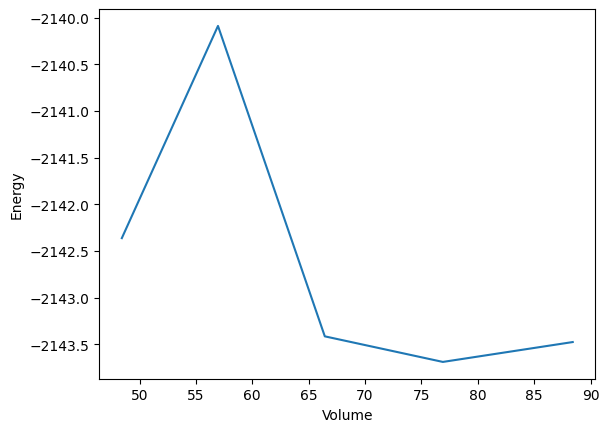

In [8]:
import matplotlib.pyplot as plt


def plot_energy_volume_curve(volume_lst, energy_lst):
    """Function to plot the final graph"""
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

eos_wg.update()
volume_lst = [structure.value.get_volume() for _, structure in eos_wg.tasks["generate_structures"].outputs["scaled_structures"].value.items()]
energy_list = [energy.value for _, energy in eos_wg.tasks["all_scf"].outputs["energies"].value.items()]
plot_energy_volume_curve(volume_lst, energy_list)